In [1]:
# Load python packages
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import statsmodels.api as sm

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
# Load R packages
library(edgeR)
library(DESeq2)
library(limma)
library(glmGamPoi)
library(glmmTMB)
library(nebula)
library(fixest)
library(MAST)
library(SingleCellExperiment)
library(scuttle)
library(lme4)

## Load data

In [3]:
# Load data
adata = sc.read_h5ad('data/Nathan/nathan.h5ad')
adata.obs

cell_id  nUMI  nGene  percent_mito  batch TB_status  \
0        AAACCCAAGGCCTAAG-1  6108   1557      0.055828      1      CASE   
1        AAACCCAAGGTTCTTG-1  7902   2149      0.083017      1      CASE   
2        AAACCCAAGTGCAGGT-1  5033   1788      0.129744      1      CASE   
3        AAACCCACAAGAGTAT-1  6574   1747      0.066930      1      CASE   
4        AAACCCACACACGGTC-1  6471   1872      0.047442      1      CASE   
...                     ...   ...    ...           ...    ...       ...   
500084  TTTGTTGTCCGCCTAT-46  1945    833      0.183033     46      CASE   
500085  TTTGTTGTCCTGGGTG-46  4534   1537      0.051610     46   CONTROL   
500086  TTTGTTGTCGATGGAG-46  3157   1013      0.081723     46      CASE   
500087  TTTGTTGTCGTTTACT-46  3675   1202      0.089252     46      CASE   
500088  TTTGTTGTCTCTTCAA-46  9072   2181      0.060185     46   CONTROL   

          UMAP_1    UMAP_2        cluster_name cluster_ids      donor  age  \
0      -2.743703  1.617194          CD4+ CD27+         C-2  TB3419057   74   
1      -4.237045  0.306832  CD4+ CCR4+ central         C-3  TB3419057   74   
2      -1.136187 -4.012949           CD4+ Treg         C-9  TB3419057   74   
3      -1.015078  3.789505    CD4+ CD27+CD161+         C-4  TB3419057   74   
4       0.658381  2.427080         CD4+ Th17/1        C-13  TB0610655   41   
...          ...       ...                 ...         ...        ...  ...   
500084 -2.568426  0.780417          CD4+ CD27+         C-2  TB9334348   28   
500085  1.017550 -0.594416            CD4+ Th1        C-17  TB2792656    9   
500086  2.301589  0.623997         CD4+ Th17/1        C-16  TB7198118   59   
500087  0.572390 -1.264730            CD4+ Th1        C-17  TB9334348   28   
500088 -3.697227  0.161370  CD4+ CCR4+ central         C-3  TB2496561   60   

       sex  season  prop_NAT  
0        F  Summer  0.957475  
1        F  Summer  0.957475  
2        F  Summer  0.957475  
3        F  Summer  0.957475  
4        M  Summer  0.975371  
...     ..     ...       ...  
500084   M  Winter  0.596238  
500085   F  Winter  0.599522  
500086   F  Summer  0.943924  
500087   M  Winter  0.596238  
500088   F  Winter  0.925586  

[500089 rows x 15 columns]

In [4]:
adata.obs['cluster_name'].value_counts()

CD4+ CD27+CD161+           45519
CD4+ CD27+                 40431
CD4+ Th17/1                39205
CD4+ Th1                   37566
CD4+ CCR4+ central         28951
CD4+ CCR4+ICOS+ central    27770
CD4+ central               26701
CD4+ Treg                  25270
CD4+ cytotoxic             23213
CD4+ Th2                   20696
CD4+ lncRNA                19901
CD4+ CD161+ Th1            17731
CD4+ CCR4+                 17321
CD8+ GZMB+                 17085
CD4+ Th17                  16987
CD8+ GZMK+                 15225
CD4+ CD161+ Th2            13662
CD4+ CD161+ cytotoxic       9320
CD4/8+ PD-1+TIGIT+          8319
Vd2                         8144
CD4+ activated              8072
CD4+ HLA-DR+                6768
CD8+ central                6398
CD4+ CD38+ICOS+ central     4891
CD8+ CXCR3+                 4343
CD4+ CCR5+ cytotoxic        4241
CD4+ RORC+ Treg             3255
CD8+ activated              2508
Vd1                          336
Name: cluster_name, dtype: int64

In [5]:
adata.obs['donor'].unique().shape

(259,)

## Subsample to 5000 cells (randomly)

In [6]:
np.random.seed(0)
cell_idx_random = np.random.binomial(
    n=1,
    p=5000/adata.shape[0],
    size=adata.shape[0]
).astype(bool)
adata_sub = adata[cell_idx_random,:].copy()

## Benchmark preprocessing

1. Select cell-type.
2. Assign random treatment label.
3. Select transcripts with > 10 counts.
4. Output count matrix $\texttt{Y}$, design matrix $\texttt{X}$, size fator $\texttt{sf}$ and membership label.

In [7]:
# label definition: column name in adata.obs
var_celltype = 'cluster_name'
var_subject = 'donor'
var_treat_random = 'TB_status'

# select transcripts with >10 counts
gene_idx_threshold = np.asarray(np.sum(adata_sub.X, axis=0) > 10).ravel()

# Produce Y, X, sf
matrix_count = adata_sub.X[:, gene_idx_threshold].tocsc()
matrix_design = sm.add_constant(
    pd.get_dummies(
        adata_sub.obs[var_treat_random], 
        drop_first=True
    )
).values
cell_sizefactor = np.asarray(np.sum(adata_sub.X, axis=1)).ravel()
cell_sizefactor = cell_sizefactor / cell_sizefactor.mean()
cell_subject = pd.factorize(adata_sub.obs[var_subject])[0]

## Pseudobulk generation

1. Aggregate(=sum) cell counts according to treatment & subject label

In [8]:
# convert psueobulk label to integer
cell_label_pseudobulk, subject_label = pd.factorize(
    adata_sub.obs[var_subject].astype(str) + 
    '_' + 
    adata_sub.obs[var_treat_random].astype(str)
)

# generate summation matrix
spmatrix_subject_sum = sparse.csc_matrix(
    (
        np.ones(adata_sub.shape[0]),
        cell_label_pseudobulk,
        np.arange(adata_sub.shape[0]+1)
    ),
    shape = (
        subject_label.shape[0], 
        adata_sub.shape[0]
    )
)

# generate pseudobulk count, design matrix
matrix_pb_count = spmatrix_subject_sum.dot(
    adata_sub.X
)[:, gene_idx_threshold].T
matrix_pb_design = sm.add_constant(
    pd.get_dummies(
        [x.split('_')[1] for x in subject_label], 
        drop_first=True
    )
).values


## Poisson regression (robust)

In [10]:
%%time
gene_beta_rpr = np.zeros(matrix_count.shape[1])
gene_bse_rpr = np.zeros(matrix_count.shape[1])
gene_p_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_count[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_design, 
        family=sm.families.Poisson(), 
        offset=np.log(cell_sizefactor)
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_rpr[gene_idx_int] = fit.params[1]
    gene_bse_rpr[gene_idx_int] = fit.bse[1]
    gene_p_rpr[gene_idx_int] = fit.pvalues[1]

CPU times: user 2h 13min 51s, sys: 2h 35min 26s, total: 4h 49min 17s
Wall time: 6min 2s


## Negative-binomial regression (glmGamPoi, robust)

In [11]:
gene_beta_ggp = np.zeros(matrix_count.shape[1])
gene_bse_ggp = np.zeros(matrix_count.shape[1])
gene_p_ggp = np.zeros(matrix_count.shape[1])
matrix_count_T = matrix_count.T.tocsc()

In [ ]:
%%time
%%R -i matrix_count_T -i matrix_design -i cell_sizefactor -o gene_beta_ggp -o gene_p_ggp

matrix_count_T <- as(matrix_count_T, "dgCMatrix")
fit <- glmGamPoi::glm_gp(
    matrix_count_T, 
    matrix_design, 
    on_disk=FALSE, 
    size_factors=as.numeric(cell_sizefactor)
    )
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_ggp <- summary(fit)$Beta[,2]
gene_p_ggp <- test$pval

## Pseudobulk (edgeR)

In [ ]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_edger -o gene_beta_edger
y <- edgeR::DGEList(matrix_pb_count, group=subject_label)
y <- edgeR::calcNormFactors(y)
y <- edgeR::estimateDisp(y, matrix_pb_design)
fit <- edgeR::glmQLFit(y, matrix_pb_design)
qlf <- edgeR::glmQLFTest(fit, coef=2)

gene_p_edger <- qlf$table[,'PValue']
gene_beta_edger <- qlf$table[,'logFC']

## Pseudobulk (DESeq2)

In [ ]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_deseq2 -o gene_beta_deseq2
dds <- DESeq2::DESeqDataSetFromMatrix(
    matrix_pb_count,
    colData = matrix_pb_design,
    design = ~ 1+V2
)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- DESeq2::estimateDispersions(dds, quiet = TRUE)
dds <- DESeq2::nbinomWaldTest(dds)
        
gene_beta_deseq2 <- results(dds)[,'log2FoldChange']
gene_p_deseq2 <- results(dds)[,'pvalue']

## NB mixed model (glmmTMB)

In [ ]:
%%time
%%R -i matrix_count -i matrix_design -i cell_sizefactor -i cell_subject -o gene_beta_nbmm -o gene_p_nbmm

data <- matrix_count@x
row_indices <- matrix_count@i # i,p both 0-base like base R
indptr <- matrix_count@p

gene_beta_nbmm <- rep(0, ncol(matrix_count))
gene_p_nbmm <- rep(1, ncol(matrix_count))

for (gene_idx_int in 1:ncol(matrix_count)){
    # select gene from count matrix: manual indexing for speed
    y <- rep(0, nrow(matrix_count))
    y[row_indices[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]+1] <- data[(indptr[gene_idx_int]+1):indptr[gene_idx_int+1]]
    
    # design matrix for fixest
    df_matrix_design <- as.data.frame(matrix_design)
    df <- cbind(y, cell_subject, df_matrix_design)
    
    # glmer fit
    fit <- glmmTMB::glmmTMB(y ~ V2 + (1|cell_subject), data=df, offset=log(cell_sizefactor), family=nbinom2)
    
    
    gene_beta_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,1]
    gene_p_nbmm[gene_idx_int] <- summary(fit)$coefficients$cond[2,4]   
}

## robust NB pseudobulk

In [ ]:
%%time
%%R -i matrix_pb_count -i matrix_pb_design -i subject_label -o gene_p_pb_ggp -o gene_beta_pb_ggp -o size_factor_pb

fit <- glmGamPoi::glm_gp(
    as.matrix(matrix_pb_count),
    matrix_pb_design,
    on_disk=FALSE
)
test <- glmGamPoi::test_de(fit, contrast=`Coef_2`)

gene_beta_pb_ggp <- summary(fit)$Beta[,2]
gene_p_pb_ggp <- test$pval
size_factor_pb <- fit$size_factors

## robust Poisson pseudobulk

In [ ]:
%%time
gene_beta_pb_rpr = np.zeros(matrix_count.shape[1])
gene_bse_pb_rpr = np.zeros(matrix_count.shape[1])
gene_p_pb_rpr = np.zeros(matrix_count.shape[1])

for gene_idx_int in range(matrix_count.shape[1]):
    mod = sm.GLM(
        endog=matrix_pb_count.T[:,gene_idx_int].toarray().ravel(), 
        exog=matrix_pb_design, 
        family=sm.families.Poisson(), 
        offset=np.log(size_factor_pb) 
    )
    fit = mod.fit(cov_type='HC0', tol=1e-10)
    gene_beta_pb_rpr[gene_idx_int] = fit.params[1]
    gene_bse_pb_rpr[gene_idx_int] = fit.bse[1]
    gene_p_pb_rpr[gene_idx_int] = fit.pvalues[1]

## Result

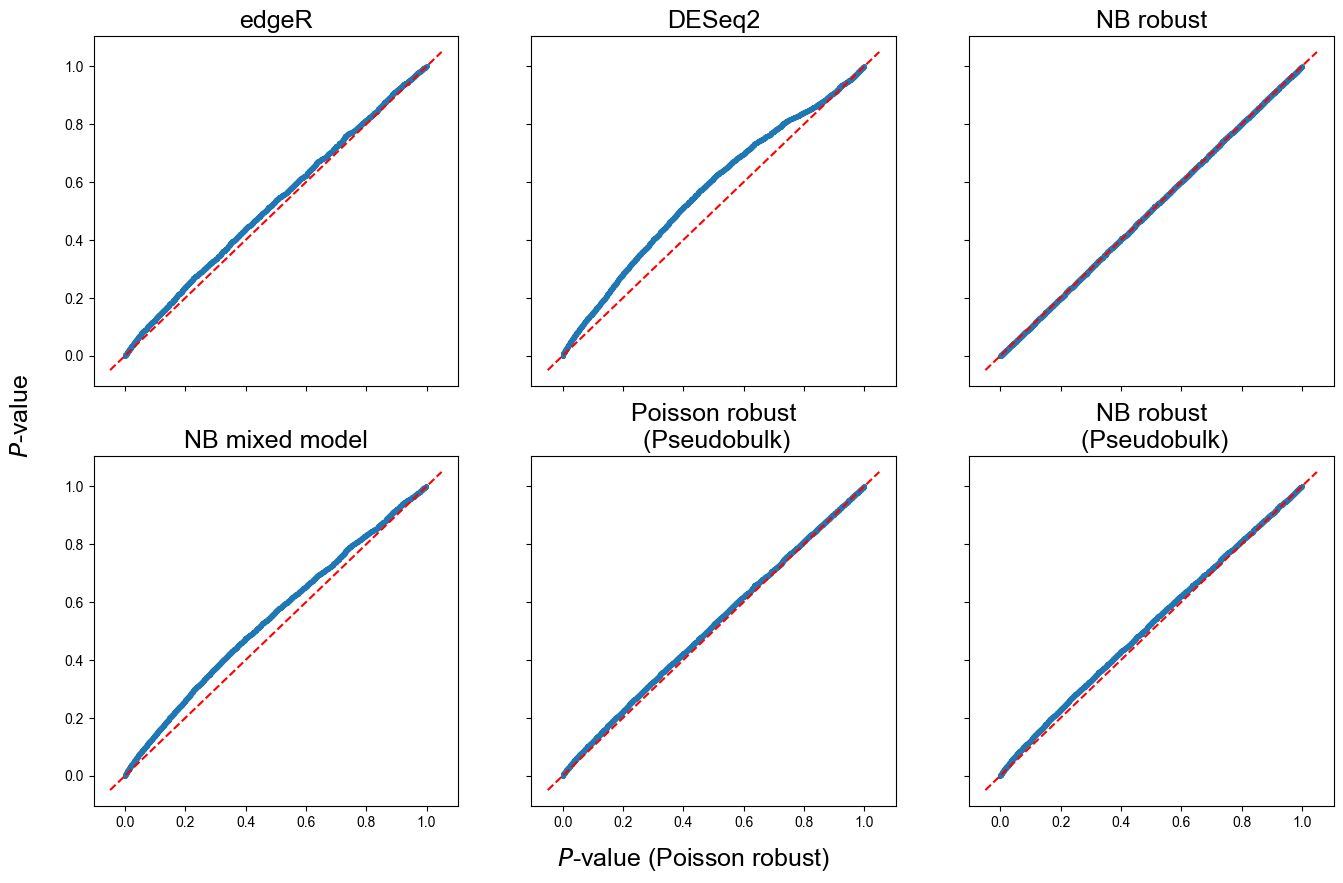

In [23]:
from decimal import Decimal
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2, 3, figsize=(5*3+1,5*2), sharex=True, sharey=True)


# main scatters
pvals = [gene_p_edger, gene_p_deseq2, gene_p_ggp, gene_p_nbmm, gene_p_pb_rpr, gene_p_pb_ggp]
labels= ['edgeR', 'DESeq2', 'NB robust', 'NB mixed model', 'Poisson robust\n (Pseudobulk)', 'NB robust\n (Pseudobulk)']
for i, pval, label in zip(range(6),pvals,labels):
    row, col = int(i/3), i%3
    ax[row, col].set_title(label, fontsize=18)
    ax[row, col].scatter(np.sort((gene_p_rpr)), np.sort((pval)), s=5)
    ax[row, col].plot([-0.05, 1.05], [-0.05,1.05], ls='--', c='red')
        

   
    

#ax[0,0].set_xlim([-0.5, 700])
#ax[0,0].set_ylim([-0.5, 700])    
fig.text(0.5, 0.05, r'$P$-value (Poisson robust)', fontsize=18, ha='center')
fig.text(0.08, 0.5, r'$P$-value', fontsize=18, rotation=90, ha='center', va='center')



plt.show()

In [24]:
import pickle
 
## Save pickle
with open("power_nathan_5000.pickle","wb") as fw:
    pickle.dump(pvals, fw)

In [ ]:
## Load pickle
with open("power_kang_5000.pickle","rb") as fr:
    pvals = pickle.load(fr)